In [29]:
import numpy as np
import pandas as pd
import altair as alt
import string
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import tkinter
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from textblob import TextBlob
from sentence_transformers import SentenceTransformer
import umap
import hdbscan


alt.renderers.enable('mimetype')
alt.data_transformers.disable_max_rows()
%matplotlib inline

In [2]:
disney_df = pd.read_csv("../data/raw/DisneylandReviews.csv")
reviews = disney_df['Review_Text']

In [3]:
reviews  

0        If you've ever been to Disneyland anywhere you...
1        Its been a while since d last time we visit HK...
2        Thanks God it wasn   t too hot or too humid wh...
3        HK Disneyland is a great compact park. Unfortu...
4        the location is not in the city, took around 1...
                               ...                        
42651    i went to disneyland paris in july 03 and thou...
42652    2 adults and 1 child of 11 visited Disneyland ...
42653    My eleven year old daughter and myself went to...
42654    This hotel, part of the Disneyland Paris compl...
42655    I went to the Disneyparis resort, in 1996, wit...
Name: Review_Text, Length: 42656, dtype: object

In [4]:
def preprocess(text):
    text = text.lower()
    text = text.replace('hk', 'hongkong')
    text = text.replace('hong kong', 'hongkong')
    text = text.replace("n't", " not")
    return text

In [5]:
reviews = reviews.apply(lambda x: preprocess(x))
reviews

0        if you've ever been to disneyland anywhere you...
1        its been a while since d last time we visit ho...
2        thanks god it wasn   t too hot or too humid wh...
3        hongkong disneyland is a great compact park. u...
4        the location is not in the city, took around 1...
                               ...                        
42651    i went to disneyland paris in july 03 and thou...
42652    2 adults and 1 child of 11 visited disneyland ...
42653    my eleven year old daughter and myself went to...
42654    this hotel, part of the disneyland paris compl...
42655    i went to the disneyparis resort, in 1996, wit...
Name: Review_Text, Length: 42656, dtype: object

In [6]:
def remove_punc(text):
    clean = ''.join([char for char in text if char not in string.punctuation])
    return clean

In [7]:
reviews = reviews.apply(lambda x: remove_punc(x))
reviews

0        if youve ever been to disneyland anywhere youl...
1        its been a while since d last time we visit ho...
2        thanks god it wasn   t too hot or too humid wh...
3        hongkong disneyland is a great compact park un...
4        the location is not in the city took around 1 ...
                               ...                        
42651    i went to disneyland paris in july 03 and thou...
42652    2 adults and 1 child of 11 visited disneyland ...
42653    my eleven year old daughter and myself went to...
42654    this hotel part of the disneyland paris comple...
42655    i went to the disneyparis resort in 1996 with ...
Name: Review_Text, Length: 42656, dtype: object

In [8]:
def remove_digit(text):
    clean = ''.join([i for i in text if not i.isdigit()])
    return clean

In [9]:
reviews = reviews.apply(lambda x: remove_digit(x))
reviews

0        if youve ever been to disneyland anywhere youl...
1        its been a while since d last time we visit ho...
2        thanks god it wasn   t too hot or too humid wh...
3        hongkong disneyland is a great compact park un...
4        the location is not in the city took around  h...
                               ...                        
42651    i went to disneyland paris in july  and though...
42652     adults and  child of  visited disneyland pari...
42653    my eleven year old daughter and myself went to...
42654    this hotel part of the disneyland paris comple...
42655    i went to the disneyparis resort in  with a sm...
Name: Review_Text, Length: 42656, dtype: object

In [10]:
tokenizer = RegexpTokenizer(r'\w+')

In [11]:
reviews_tokenized = reviews.apply(lambda x: tokenizer.tokenize(x.lower()))
reviews_tokenized 

0        [if, youve, ever, been, to, disneyland, anywhe...
1        [its, been, a, while, since, d, last, time, we...
2        [thanks, god, it, wasn, t, too, hot, or, too, ...
3        [hongkong, disneyland, is, a, great, compact, ...
4        [the, location, is, not, in, the, city, took, ...
                               ...                        
42651    [i, went, to, disneyland, paris, in, july, and...
42652    [adults, and, child, of, visited, disneyland, ...
42653    [my, eleven, year, old, daughter, and, myself,...
42654    [this, hotel, part, of, the, disneyland, paris...
42655    [i, went, to, the, disneyparis, resort, in, wi...
Name: Review_Text, Length: 42656, dtype: object

In [12]:
nltk_stopwords = pd.Series(stopwords.words("english"))
nltk_stopwords = nltk_stopwords.apply(lambda x: remove_punc(x))
nltk_stopwords = set(nltk_stopwords)

In [13]:
stopwords_700 = pd.read_csv('../EDA/stopwords.txt', header= None, delimiter = "\t")
stopwords_700 = set(stopwords_700[0])

In [14]:
def remove_stopwords(text): 
    stop_words = set(stopwords.words("english"))
    stop_words_customize = {'disney', 'disneyland', 'land', 'park', 'parks', 'world', 'disneyworld', 'disney world', 'one'}
    stop_words_all = nltk_stopwords.union(stopwords_700, stop_words_customize)
    clean = [word for word in text if not word in stop_words_all]
    return clean

In [15]:
reviews_nostop = reviews_tokenized.apply(lambda x: remove_stopwords(x))

In [16]:
reviews_nostop

0        [find, hongkong, similar, layout, walk, street...
1        [last, time, visit, hongkong, time, stay, tomo...
2        [thanks, god, hot, humid, visiting, big, issue...
3        [hongkong, great, compact, unfortunately, bit,...
4        [location, city, took, hour, kowlon, kids, lik...
                               ...                        
42651    [went, paris, july, thought, brilliant, visite...
42652    [adults, child, visited, paris, beginning, feb...
42653    [eleven, year, old, daughter, went, visit, son...
42654    [hotel, part, paris, complex, wonderful, place...
42655    [went, disneyparis, resort, small, child, minu...
Name: Review_Text, Length: 42656, dtype: object

In [17]:
lemmatizer = WordNetLemmatizer()

def text_lemmatizer(text):
    lemmatized_text = [lemmatizer.lemmatize(i) for i in text]
    return lemmatized_text

In [18]:
reviews_lemmatized = reviews_nostop.apply(lambda x: text_lemmatizer(x))
reviews_lemmatized

0        [find, hongkong, similar, layout, walk, street...
1        [last, time, visit, hongkong, time, stay, tomo...
2        [thanks, god, hot, humid, visiting, big, issue...
3        [hongkong, great, compact, unfortunately, bit,...
4        [location, city, took, hour, kowlon, kid, like...
                               ...                        
42651    [went, paris, july, thought, brilliant, visite...
42652    [adult, child, visited, paris, beginning, feb,...
42653    [eleven, year, old, daughter, went, visit, son...
42654    [hotel, part, paris, complex, wonderful, place...
42655    [went, disneyparis, resort, small, child, minu...
Name: Review_Text, Length: 42656, dtype: object

In [19]:
stemmer = PorterStemmer()

def text_stemmer(text):
    stem_text = ' '.join([stemmer.stem(i) for i in text])
    return stem_text

In [20]:
reviews_clean = reviews_lemmatized.apply(lambda x: text_stemmer(x))
reviews_clean

0        find hongkong similar layout walk street famil...
1        last time visit hongkong time stay tomorrowlan...
2        thank god hot humid visit big issu shadei arri...
3        hongkong great compact unfortun bit mainten wo...
4        locat citi took hour kowlon kid like fine crow...
                               ...                        
42651    went pari juli thought brilliant visit hotel s...
42652    adult child visit pari begin feb absolut fanta...
42653    eleven year old daughter went visit son london...
42654    hotel part pari complex wonder place famili ki...
42655    went disneypari resort small child minut enter...
Name: Review_Text, Length: 42656, dtype: object

In [24]:
reviews_clean[0:100]

0     find hongkong similar layout walk street famil...
1     last time visit hongkong time stay tomorrowlan...
2     thank god hot humid visit big issu shadei arri...
3     hongkong great compact unfortun bit mainten wo...
4     locat citi took hour kowlon kid like fine crow...
                            ...                        
95    fantast nice place kid friendli easli food are...
96    love attract well run well worth visit fun day...
97    friendli staff cool weather klook purchas disc...
98    smallest spent day tokyo februari compar hongk...
99    im big fan regular visitor pari excit visit ne...
Name: Review_Text, Length: 100, dtype: object

### embeddings

In [41]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(reviews_clean[0:10000], show_progress_bar=True)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [42]:
embeddings

array([[-0.61559373, -0.20032671,  1.0582038 , ...,  0.9975504 ,
        -0.4581424 ,  0.03603208],
       [-0.47098354, -0.03963627,  0.6322097 , ..., -0.10901412,
         0.48260885, -0.88283473],
       [-0.27956465,  0.10112793,  1.012869  , ..., -0.33050764,
         0.17098844, -0.5432792 ],
       ...,
       [-0.5662333 , -0.5549518 ,  1.295568  , ...,  0.06220243,
         0.38679737, -0.64116323],
       [-0.3568425 , -0.01583724,  0.8682619 , ..., -0.07331721,
        -0.23523916, -1.2756348 ],
       [-0.75947547, -0.4277764 ,  1.0213318 , ...,  0.32073   ,
         0.12111425, -0.6743578 ]], dtype=float32)

In [43]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [44]:
umap_embeddings

array([[12.786706  ,  6.9205127 ,  9.938792  , -1.5790036 ,  6.113254  ],
       [14.182943  ,  5.3161693 , 11.660484  , -1.5909827 ,  6.2665787 ],
       [14.065703  ,  6.8789554 , 10.561566  , -2.772793  ,  5.392345  ],
       ...,
       [12.155813  ,  6.4299407 , 10.206727  , -1.3287188 ,  5.2335873 ],
       [11.896694  ,  6.2989707 , 10.144082  , -1.1708366 ,  5.494611  ],
       [11.437541  ,  6.0832067 ,  9.489707  , -0.97772914,  5.920983  ]],
      dtype=float32)

In [45]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [46]:
cluster

HDBSCAN(min_cluster_size=15)

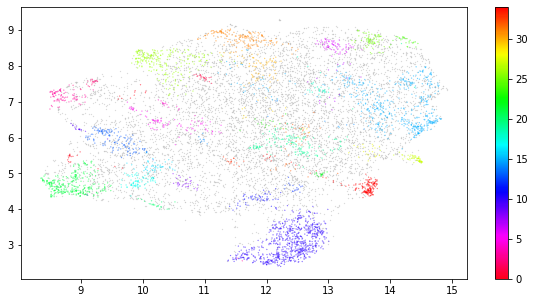

In [47]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 5))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()